In [62]:
import numpy as np
import jax.numpy as jnp
import librosa as lr
import librosa.display as lrd
import torch
import sys
import os
import matplotlib.pyplot as plt

sys.path.append('..')

from jax import jit, vmap
from drone_audition.datasets.dregon import DregonDataset
from drone_audition.datasets.utils import normalize_volume
from env import settings

from utils import show_wav, plot_dwim

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [138]:
def plt_wav_speeds(item, figsize=(15, 10)):
    fig, axes = plt.subplots(figsize=figsize, nrows=3, ncols=1, sharex=True)
    plt.sca(axes[0])
    wav = item['wav']
    if len(wav.shape) > 1:
        wav = wav[0, :]
        
    plt.plot(item['ts'], wav)
    plt.ylabel('Amplitude')
    
    plt.sca(axes[1])
    for i in range(4):
        plt.plot(item['ts'].flatten(), item['motor_speed'][i], label=f'm{i}', alpha=0.5)
    
    plt.ylabel('Motor speed')
    plt.xlabel('Time')
    plt.legend()
    
    plt.sca(axes[2])
    plt.plot(item['ts'].flatten(), item['angular_velocity'][2], label='ang.velocity (z-axis)', alpha=0.5)
    plt.plot(item['ts'].flatten(), item['acceleration'][2], label='acceleration (z-axis)', alpha=0.5)
    plt.ylabel('IMU measurements')
    plt.xlabel('Time')
    plt.legend()
    
def plot_avg_mag(wav, log=False, **kwargs):
    avg_mag = jnp.mean(jnp.abs(lr.stft(np.array(wav), center=False, **kwargs)), axis=-1)
    if log:
        avg_mag = jnp.log(avg_mag)
    return plt.plot(jnp.arange(len(avg_mag)), avg_mag)

def plot_avg_mag_with_log(wav, **kwargs):
    fig, axes = plt.subplots(figsize=(10, 4), nrows=1, ncols=2)
    plt.sca(axes[0])
    plot_avg_mag(wav, **kwargs)
    plt.sca(axes[1])
    plot_avg_mag(wav, log=True, **kwargs)
    fig.tight_layout()

In [5]:
dregon = DregonDataset(data_dir=settings.DREGON_PATH, sample_rate=settings.SAMPLE_RATE)

In [6]:
item = dregon[0]
item['wav'].shape

(8, 166237)

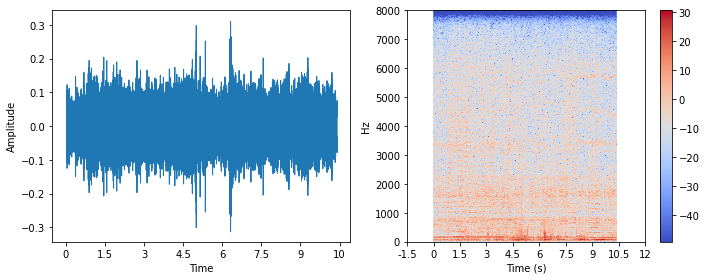

In [7]:
show_wav(item['wav'][5])

CHANNEL 0


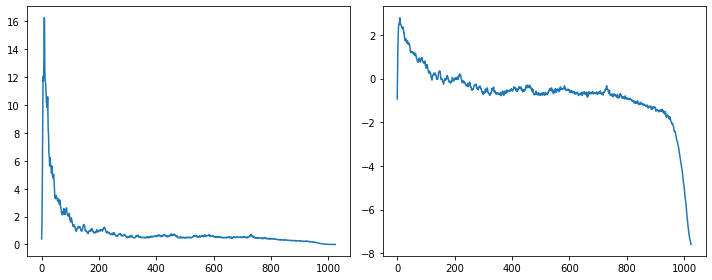

CHANNEL 1


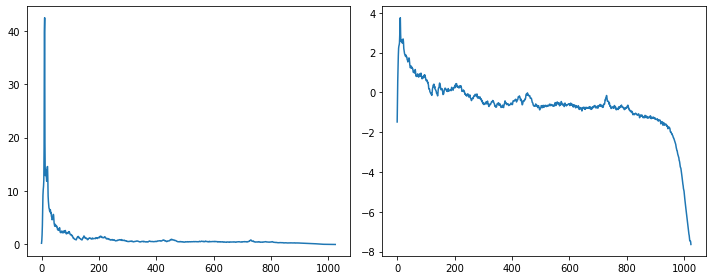

CHANNEL 2


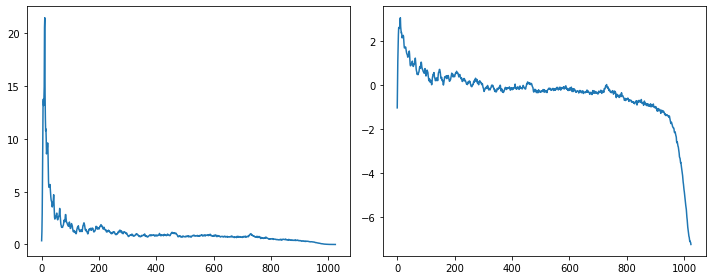

CHANNEL 3


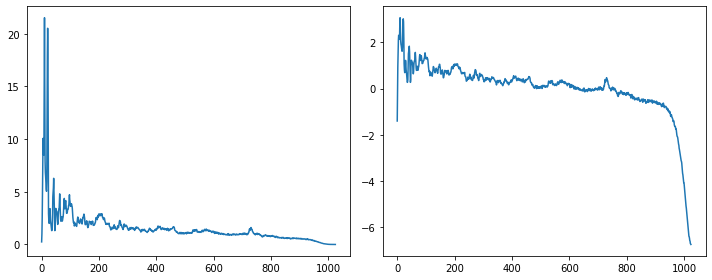

CHANNEL 4


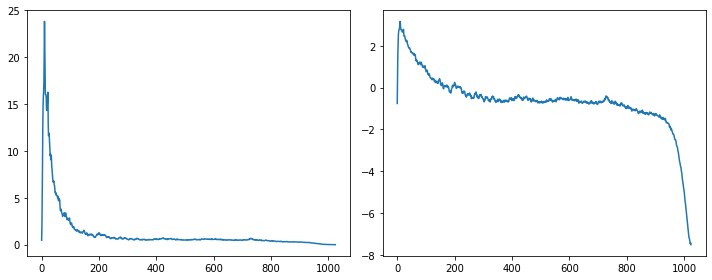

CHANNEL 5


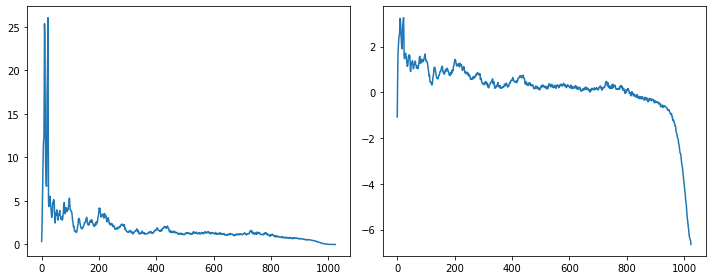

CHANNEL 6


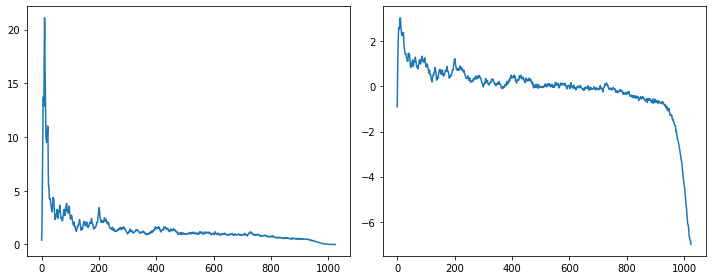

CHANNEL 7


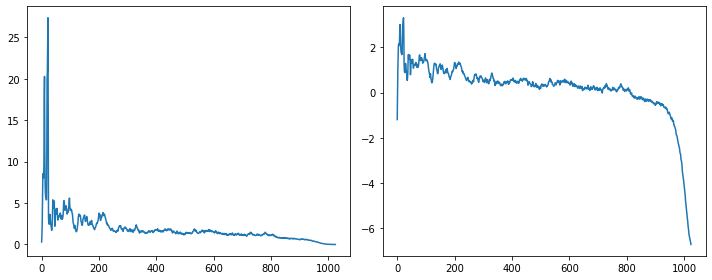

In [150]:
for i in range(8):
    print(f'CHANNEL {i}')
    plot_avg_mag_with_log(normalize_volume(item['wav'][i]))
    plt.show()

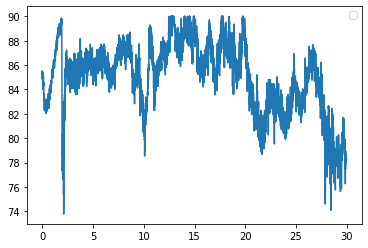

In [10]:
plot_dwim(item['ts'], item['motor_speed'][0])

In [13]:
sample = item['motor_speed'][0][:2000]

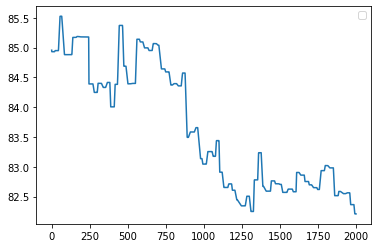

In [14]:
plot_dwim(sample)

In [171]:
@jit
def rps_to_bpf_phase(rps, blades_per_propeller=2, starting_phase=0, sr=settings.SAMPLE_RATE):
    bpf = rps * blades_per_propeller
    phase_diff = bpf * 2 * jnp.pi / sr
    unwrapped_phase = jnp.cumsum(phase_diff) + starting_phase
    return unwrapped_phase % (2 * jnp.pi)

@jit
def rps_to_bpf_wav(*args, **kwargs):
    return jnp.sin(rps_to_bpf_phase(*args, **kwargs))

def rps_to_bpf_harmonics(rps, num_harmonics=60, **kwargs):
    coeffs = jnp.expand_dims(jnp.arange(1, num_harmonics + 1), axis=1)
    rpss = jnp.dot(coeffs, jnp.expand_dims(rps, axis=0))
    return vmap(rps_to_bpf_wav)(rpss)

@jit
def rps_to_harmonic_sum(rps, num_harmonics=60, **kwargs):
    harmonics = rps_to_bpf_harmonics(rps, num_harmonics, **kwargs)
    coeffs = 1 / jnp.arange(1, num_harmonics + 1)
    return normalize_volume(jnp.dot(jnp.expand_dims(coeffs, 0), harmonics).flatten())
    

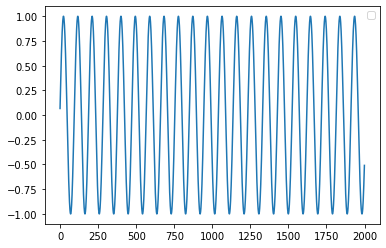

In [159]:
plot_dwim(rps_to_bpf_wav(sample))

In [45]:
wav_in_question = item['wav'][3]

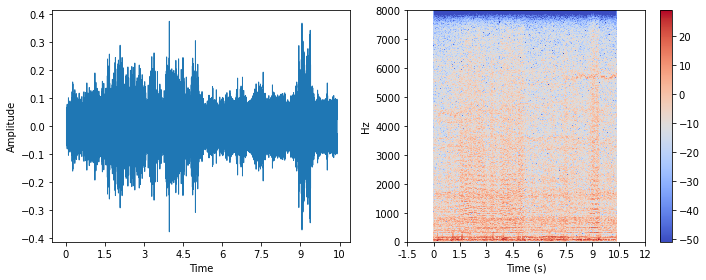

In [46]:
show_wav(wav_in_question)

In [49]:
bpf_wav_4ch = vmap(rps_to_bpf_wav)(item['motor_speed'])

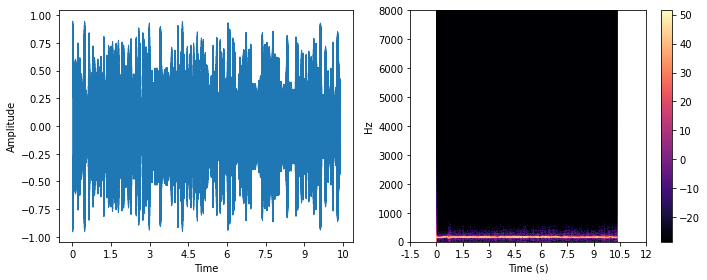

In [63]:
show_wav(normalize_volume(bpf_wav_4ch.sum(axis=0)))

In [172]:
harmonic_sum = rps_to_harmonic_sum(item['motor_speed'][2])

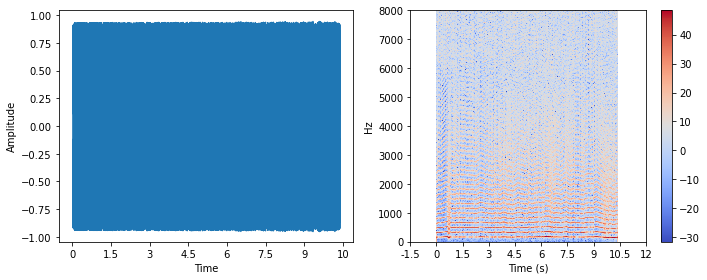

In [173]:
show_wav(harmonic_sum)

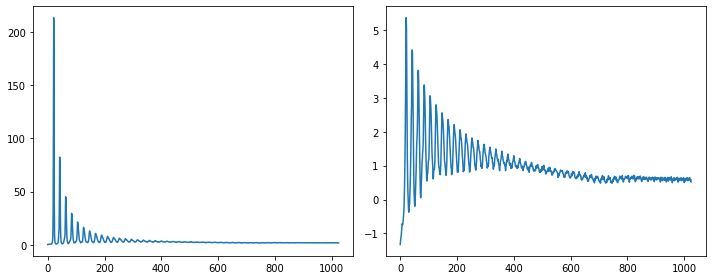

In [175]:
plot_avg_mag_with_log(harmonic_sum)

In [180]:
vectorized = vmap(rps_to_harmonic_sum)

In [182]:
harmonics_4engines = vectorized(item['motor_speed'])

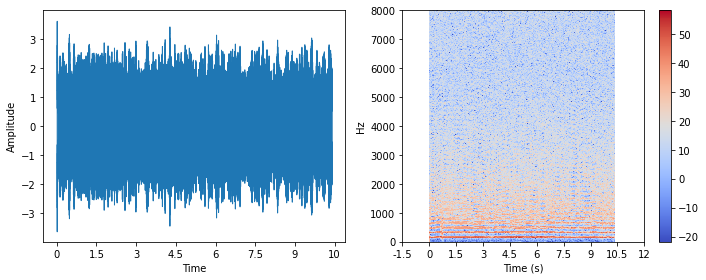

In [184]:
show_wav(harmonics_4engines.sum(axis=0))